In [1]:
%pip install pandas matplotlib scipy seaborn ipyfilechooser

Note: you may need to restart the kernel to use updated packages.


In [69]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from dateutil import tz

In [70]:
from scipy.signal import savgol_filter

from common import combine_csvs

In [71]:
MEGAb_TO_b = 1e6
TCP_DOWN = "*down.*.csv"
UDP_DOWN = "*down*udp*.csv"
TCP_UP = "*receive.*[!p].csv"
UDP_UP = "*receive*.udp.csv"
TEMP='Temp (°C)'
PRECIP='Precip. Amount (mm)'

JITTER = 'jitter_ms'
BANDWIDTH = 'bandwidth'

In [72]:
#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
sns.set_context("paper", rc={"font.size":9,"axes.titlesize":9,"axes.labelsize":8, "xtick.labelsize":8})

In [73]:
def convert_to_mb(df):
    # Converts to Megabits per second
    df.bits_per_second /= MEGAb_TO_b
    df.rename(columns={'bits_per_second': 'bandwidth'}, inplace=True)

In [74]:
def concat_df(src, pattern, keep=['bandwidth']):
    files = glob.glob(f"{src}/**/{pattern}", recursive=True)
    combined_df = combine_csvs(files)
    
    combined_df.index = pd.to_datetime(combined_df.index, unit='s')
    convert_to_mb(combined_df)
    combined_df = combined_df[keep]
    return combined_df

In [75]:
def remove_first_measures(df, first=3):
    # Remove first {first} datapoints for each measurement
    # Take into account of software tool overhead
    diff_time = (df.index - df.reset_index().timestamp.shift())
    # Choose entries where previous time is less than an hour
    first_measure_map = diff_time < pd.Timedelta(5, unit='m')
    # Propagate to first three datapoints
    for i in range(1, first):
        first_measure_map = first_measure_map.eq(first_measure_map.shift(i))

    df_map = pd.DataFrame(columns=df.columns)
    df_map.iloc[:,0] = first_measure_map
    df_map['timestamp'] = df.index
    df_map.set_index('timestamp', inplace=True)
    filtered_df = df.where(df_map, -1) # Set to -1

    return filtered_df

In [76]:
def combine_reg(src, pattern, keep='bandwidth', first=3):
    regions_df = pd.DataFrame()
    start = True
    for region in glob.glob(f"{src}/*"):
        combined_df = concat_df(region, pattern, [keep]).sort_values('timestamp')
        reg_name = os.path.basename(region)
        combined_df.rename(columns={keep: reg_name}, inplace=True)
        combined_df = remove_first_measures(combined_df, first)

        if start:
            regions_df = combined_df
            start = False
        else:
            regions_df = pd.merge(regions_df, combined_df, how='outer', left_index=True, right_index=True)

    return regions_df

In [77]:
from ipyfilechooser import FileChooser

# Create and display a FileChooser widget
fc = FileChooser('data/Home_network_data/Iperf_csv/')
fc.sandbox_path = 'data/Home_network_data/Iperf_csv/'
display(fc)

FileChooser(path='/home/sami/starlink-plot/data/Home_network_data', filename='', title='', show_hidden=False, …

In [78]:
fc1 = FileChooser('data/starlink-data/Iperf_csv/')
fc1.sandbox_path = 'data/starlink-data/Iperf_csv/'
display(fc1)

FileChooser(path='/home/sami/starlink-plot/data/starlink-data', filename='', title='', show_hidden=False, sele…

In [79]:
#src_dirs = [('Starlink', 'data/Starlink_csv_2022_04-07_to_04-12/')]
#src_dirs = [('Home', 'data/Home_network_data/Iperf_csv/2022-01-19_trad_iperf/')]
src_dirs = []
if fc1.selected_path:
    src_dirs.append(('Starlink', fc1.selected_path))
if fc.selected_path:
    src_dirs.append(('Home', fc.selected_path))
src_dirs

[('Starlink',
  '/home/sami/starlink-plot/data/starlink-data/Iperf_csv/2022-06-03_starlink_throughput_measurements'),
 ('Home',
  '/home/sami/starlink-plot/data/Home_network_data/Iperf_csv/2022-06-03_traditional_measures_throughput')]

In [170]:
df = pd.DataFrame()
for type_name, folder in src_dirs:
    #df = concat_df(args.src_folder, UDP_UP, [JITTER])
    df_temp = combine_reg(folder, UDP_UP, first=1)
    df_temp = pd.concat({type_name: df_temp}, axis=1)
    if not df.empty:
        df = df.merge(df_temp, how='outer', left_index=True, right_index=True)
    else:
        df = df_temp
df

Starlink                         \
                              South_America_Sao_Paulo Asia_Pacific_Singapore   
timestamp                                                                      
2022-06-03 09:24:15.000000000                     NaN                    NaN   
2022-06-03 09:24:16.001029888                     NaN                    NaN   
2022-06-03 09:24:17.000070144                     NaN                    NaN   
2022-06-03 09:24:18.000073984                     NaN                    NaN   
2022-06-03 09:24:19.000062976                     NaN                    NaN   
...                                               ...                    ...   
2022-06-05 05:15:02.000076032                     NaN                    NaN   
2022-06-05 05:15:03.000071168                     NaN                    NaN   
2022-06-05 05:15:04.000073984                     NaN                    NaN   
2022-06-05 05:15:05.000070144                     NaN                    NaN   
2022-06-05 05:15:06.000071936                     NaN                    NaN   

                                                                    \
                              Asia_Pacific_Sydney Africa_Cape_Town   
timestamp                                                            
2022-06-03 09:24:15.000000000           -1.000000              NaN   
2022-06-03 09:24:16.001029888           12.511145              NaN   
2022-06-03 09:24:17.000070144           15.371909              NaN   
2022-06-03 09:24:18.000073984           15.348968              NaN   
2022-06-03 09:24:19.000062976           15.533677              NaN   
...                                           ...              ...   
2022-06-05 05:15:02.000076032                 NaN        15.754319   
2022-06-05 05:15:03.000071168                 NaN        16.588241   
2022-06-05 05:15:04.000073984                 NaN        15.325690   
2022-06-05 05:15:05.000070144                 NaN        14.422052   
2022-06-05 05:15:06.000071936                 NaN        13.395051   

                                                                        \
                              US_West_N_California Middle_East_Bahrain   
timestamp                                                                
2022-06-03 09:24:15.000000000                  NaN                 NaN   
2022-06-03 09:24:16.001029888                  NaN                 NaN   
2022-06-03 09:24:17.000070144                  NaN                 NaN   
2022-06-03 09:24:18.000073984                  NaN                 NaN   
2022-06-03 09:24:19.000062976                  NaN                 NaN   
...                                            ...                 ...   
2022-06-05 05:15:02.000076032                  NaN                 NaN   
2022-06-05 05:15:03.000071168                  NaN                 NaN   
2022-06-05 05:15:04.000073984                  NaN                 NaN   
2022-06-05 05:15:05.000070144                  NaN                 NaN   
2022-06-05 05:15:06.000071936                  NaN                 NaN   

                                                                \
                              Asia_Pacific_Tokyo Europe_London   
timestamp                                                        
2022-06-03 09:24:15.000000000                NaN           NaN   
2022-06-03 09:24:16.001029888                NaN           NaN   
2022-06-03 09:24:17.000070144                NaN           NaN   
2022-06-03 09:24:18.000073984                NaN           NaN   
2022-06-03 09:24:19.000062976                NaN           NaN   
...                                          ...           ...   
2022-06-05 05:15:02.000076032                NaN           NaN   
2022-06-05 05:15:03.000071168                NaN           NaN   
2022-06-05 05:15:04.000073984                NaN           NaN   
2022-06-05 05:15:05.000070144                NaN           NaN   
2022-06-05 05:15:06.000071936                NaN

In [145]:
df_regs = df.replace(-1, pd.NA)
df_regs = df_regs.astype(object).where(df_regs.notnull(), None)
df_regs = df_regs.dropna(how='all').astype(float)
#df = concat_df(args.src_folder, UDP_DOWN).sort_values('timestamp')
#df_regs = df_regs.loc['2022-05-28 18:13:00':]
#df = df.loc['2022-03-01 04:07:30':'2022-03-01 04:08:40']
#df = df.loc['2022-03-01':'2022-03-02']

df_regs

Starlink                         \
                              South_America_Sao_Paulo Asia_Pacific_Singapore   
timestamp                                                                      
2022-06-03 09:24:16.001029888                     NaN                    NaN   
2022-06-03 09:24:17.000070144                     NaN                    NaN   
2022-06-03 09:24:18.000073984                     NaN                    NaN   
2022-06-03 09:24:19.000062976                     NaN                    NaN   
2022-06-03 09:24:20.000092928                     NaN                    NaN   
...                                               ...                    ...   
2022-06-05 05:15:02.000076032                     NaN                    NaN   
2022-06-05 05:15:03.000071168                     NaN                    NaN   
2022-06-05 05:15:04.000073984                     NaN                    NaN   
2022-06-05 05:15:05.000070144                     NaN                    NaN   
2022-06-05 05:15:06.000071936                     NaN                    NaN   

                                                                    \
                              Asia_Pacific_Sydney Africa_Cape_Town   
timestamp                                                            
2022-06-03 09:24:16.001029888           12.511145              NaN   
2022-06-03 09:24:17.000070144           15.371909              NaN   
2022-06-03 09:24:18.000073984           15.348968              NaN   
2022-06-03 09:24:19.000062976           15.533677              NaN   
2022-06-03 09:24:20.000092928           15.847260              NaN   
...                                           ...              ...   
2022-06-05 05:15:02.000076032                 NaN        15.754319   
2022-06-05 05:15:03.000071168                 NaN        16.588241   
2022-06-05 05:15:04.000073984                 NaN        15.325690   
2022-06-05 05:15:05.000070144                 NaN        14.422052   
2022-06-05 05:15:06.000071936                 NaN        13.395051   

                                                                        \
                              US_West_N_California Middle_East_Bahrain   
timestamp                                                                
2022-06-03 09:24:16.001029888                  NaN                 NaN   
2022-06-03 09:24:17.000070144                  NaN                 NaN   
2022-06-03 09:24:18.000073984                  NaN                 NaN   
2022-06-03 09:24:19.000062976                  NaN                 NaN   
2022-06-03 09:24:20.000092928                  NaN                 NaN   
...                                            ...                 ...   
2022-06-05 05:15:02.000076032                  NaN                 NaN   
2022-06-05 05:15:03.000071168                  NaN                 NaN   
2022-06-05 05:15:04.000073984                  NaN                 NaN   
2022-06-05 05:15:05.000070144                  NaN                 NaN   
2022-06-05 05:15:06.000071936                  NaN                 NaN   

                                                                \
                              Asia_Pacific_Tokyo Europe_London   
timestamp                                                        
2022-06-03 09:24:16.001029888                NaN           NaN   
2022-06-03 09:24:17.000070144                NaN           NaN   
2022-06-03 09:24:18.000073984                NaN           NaN   
2022-06-03 09:24:19.000062976                NaN           NaN   
2022-06-03 09:24:20.000092928                NaN           NaN   
...                                          ...           ...   
2022-06-05 05:15:02.000076032                NaN           NaN   
2022-06-05 05:15:03.000071168                NaN           NaN   
2022-06-05 05:15:04.000073984                NaN           NaN   
2022-06-05 05:15:05.000070144                NaN           NaN   
2022-06-05 05:15:06.000071936                NaN

In [169]:
df_outage = df_regs.fillna(-1)
df_outage = df_outage[df_outage == 0].dropna(how='all')
df_outage = df_outage.unstack().dropna(how=all)
df_outage = df_unstacked.reset_index(drop=True)
df_outage.rename(columns={'level_0': N_TYPE, 'level_1': N_REGIONS},
        inplace=True)
df_outage

,Type,Regions,timestamp,bandwidth
0,Starlink,South_America_Sao_Paulo,2022-06-03 10:18:00,11.126501
1,Starlink,South_America_Sao_Paulo,2022-06-03 10:19:00,11.114772
2,Starlink,South_America_Sao_Paulo,2022-06-03 10:20:00,11.103042
3,Starlink,South_America_Sao_Paulo,2022-06-03 10:21:00,11.091313
4,Starlink,South_America_Sao_Paulo,2022-06-03 10:22:00,11.079583
...,...,...,...,...
36531,Home,Asia_Pacific_Mumbai,2022-06-05 05:11:00,109.007887
36532,Home,Asia_Pacific_Mumbai,2022-06-05 05:12:00,109.007887
36533,Home,Asia_Pacific_Mumbai,2022-06-05 05:13:00,109.007887
36534,Home,Asia_Pacific_Mumbai,2022-06-05 05:14:00,109.007887


In [146]:
# Aggreagation options
df_regs_interp = df_regs
df_regs_interp = df_regs_interp.resample('H').mean()
df_regs_interp = df_regs_interp.interpolate(method='linear')
df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,91,1))
# Perform savgol filtering
df_regs_interp

#df.to_csv("out.csv", encoding='utf-8-sig')


Starlink                         \
                    South_America_Sao_Paulo Asia_Pacific_Singapore   
timestamp                                                            
2022-06-03 09:24:00                     NaN                    NaN   
2022-06-03 09:25:00                     NaN                    NaN   
2022-06-03 09:26:00                     NaN                    NaN   
2022-06-03 09:27:00                     NaN                    NaN   
2022-06-03 09:28:00                     NaN                    NaN   
...                                     ...                    ...   
2022-06-05 05:11:00                8.977845               8.802560   
2022-06-05 05:12:00                8.988057               8.920133   
2022-06-05 05:13:00                8.998269               9.037705   
2022-06-05 05:14:00                9.008481               9.155278   
2022-06-05 05:15:00                9.018693               9.272850   

                                                                               \
                    Asia_Pacific_Sydney Africa_Cape_Town US_West_N_California   
timestamp                                                                       
2022-06-03 09:24:00           12.593592              NaN                  NaN   
2022-06-03 09:25:00           12.567962              NaN                  NaN   
2022-06-03 09:26:00           12.542332              NaN                  NaN   
2022-06-03 09:27:00           12.516702              NaN                  NaN   
2022-06-03 09:28:00           12.491072              NaN                  NaN   
...                                 ...              ...                  ...   
2022-06-05 05:11:00            7.636729        16.517699            11.745282   
2022-06-05 05:12:00            7.634747        16.680581            11.772852   
2022-06-05 05:13:00            7.632765        16.843464            11.800421   
2022-06-05 05:14:00            7.630783        17.006346            11.827991   
2022-06-05 05:15:00            7.628801        17.169229            11.855560   

                                                                          \
                    Middle_East_Bahrain Asia_Pacific_Tokyo Europe_London   
timestamp                                                                  
2022-06-03 09:24:00                 NaN                NaN           NaN   
2022-06-03 09:25:00                 NaN                NaN           NaN   
2022-06-03 09:26:00                 NaN                NaN           NaN   
2022-06-03 09:27:00                 NaN                NaN           NaN   
2022-06-03 09:28:00                 NaN                NaN           NaN   
...                                 ...                ...           ...   
2022-06-05 05:11:00            6.143066           0.757638      9.424388   
2022-06-05 05:12:00            6.080346           0.639105      9.458661   
2022-06-05 05:13:00            6.017626           0.520571      9.492935   
2022-06-05 05:14:00            5.954906           0.402037      9.527208   
2022-06-05 05:15:00            5.892186           0.283503      9.561481   

                                                           Home  \
                    Asia_Pacific_Mumbai South_America_Sao_Paulo   
timestamp                                                         
2022-06-03 09:24:00                 NaN                     NaN   
2022-06-03 09:25:00                 NaN                     NaN   
2022-06-03 09:26:00                 NaN                     NaN   
2022-06-03 09:27:00                 NaN                     NaN   
2022-06-03 09:28:00                 NaN                     NaN   
...                                 ...                     ...   
2022-06-05 05:11:00            7.859527              109.086348   
2022-06-05 05:12:00            7.796609              109.086348   
2022-06-05 05:13:00            7.733690              109.086348   
2022-06-05 05:14:00            7.670771           

In [147]:
N_REGIONS = 'Regions'
N_TIMESTAMP = 'Timestamp'
N_TYPE = 'Type'

df_unstacked = df_regs_interp.unstack().dropna(how=all)
df_unstacked = df_unstacked.mask(df_unstacked == -1).reset_index(name=BANDWIDTH)
df_unstacked.rename(columns={'level_0': N_TYPE, 'level_1': N_REGIONS},
        inplace=True)

df_unstacked

,Type,Regions,timestamp,bandwidth
0,Starlink,South_America_Sao_Paulo,2022-06-03 10:18:00,11.126501
1,Starlink,South_America_Sao_Paulo,2022-06-03 10:19:00,11.114772
2,Starlink,South_America_Sao_Paulo,2022-06-03 10:20:00,11.103042
3,Starlink,South_America_Sao_Paulo,2022-06-03 10:21:00,11.091313
4,Starlink,South_America_Sao_Paulo,2022-06-03 10:22:00,11.079583
...,...,...,...,...
36531,Home,Asia_Pacific_Mumbai,2022-06-05 05:11:00,109.007887
36532,Home,Asia_Pacific_Mumbai,2022-06-05 05:12:00,109.007887
36533,Home,Asia_Pacific_Mumbai,2022-06-05 05:13:00,109.007887
36534,Home,Asia_Pacific_Mumbai,2022-06-05 05:14:00,109.007887


AttributeError: 'list' object has no attribute 'yaxis'

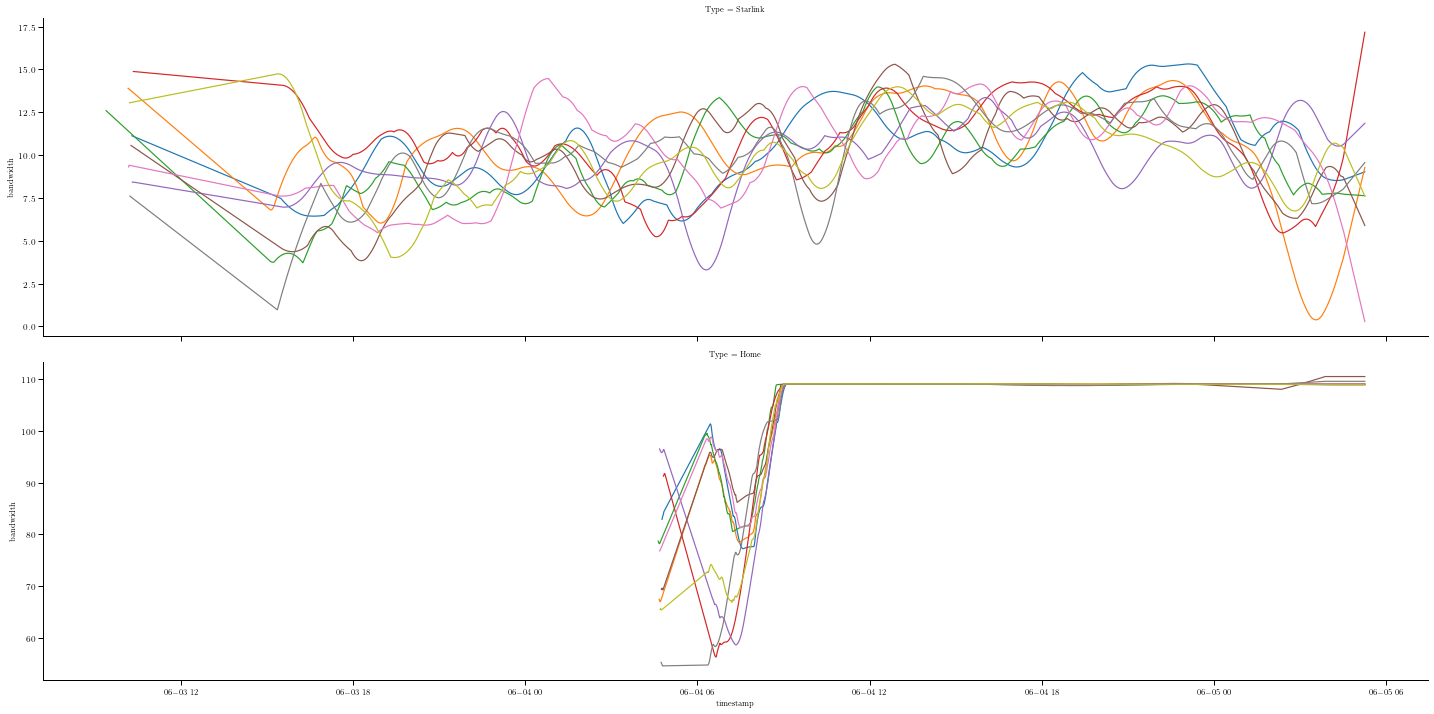

In [148]:
#fig, ax = plt.subplots(figsize=(3.5,3))
#fig, ax = plt.subplots(figsize=(20,10))

#ax.xaxis.update_units(df.index)
#y_val = df_unstacked.bandwidth
#sns.scatterplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)
#sns.jointplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)

#sns.lineplot(x=ax.xaxis.convert_units(df.index), y=y_val, ax=ax, hue=y_val.isna().cumsum(),
#        palette=["black"]*sum(y_val.isna()), markers=True, legend=False)
#sns.lineplot(data=df_regs)

g = sns.FacetGrid(data=df_unstacked, row=N_TYPE, hue=N_REGIONS, sharey=False, height=5, aspect=4)
g.map(sns.lineplot, 'timestamp', 'bandwidth')

g_ax = g.fig.axes
sns.scatterplot(data=df_outage, ax=g_ax)


#g = sns.lineplot(data=df_unstacked, x='timestamp', y='bandwidth', hue=N_REGIONS, style=N_TYPE)
#g = sns.lineplot(data=df_unstacked, x=df_unstacked.index, y='bandwidth')
#ax.set(yscale='log')
g.figure.autofmt_xdate()

#ax.set_ylabel("Jitter (ms)")
g.add_legend()
g.set(ylabel="Bandwidth (Mb/s)")
g.tight_layout()
#fig.tight_layout()

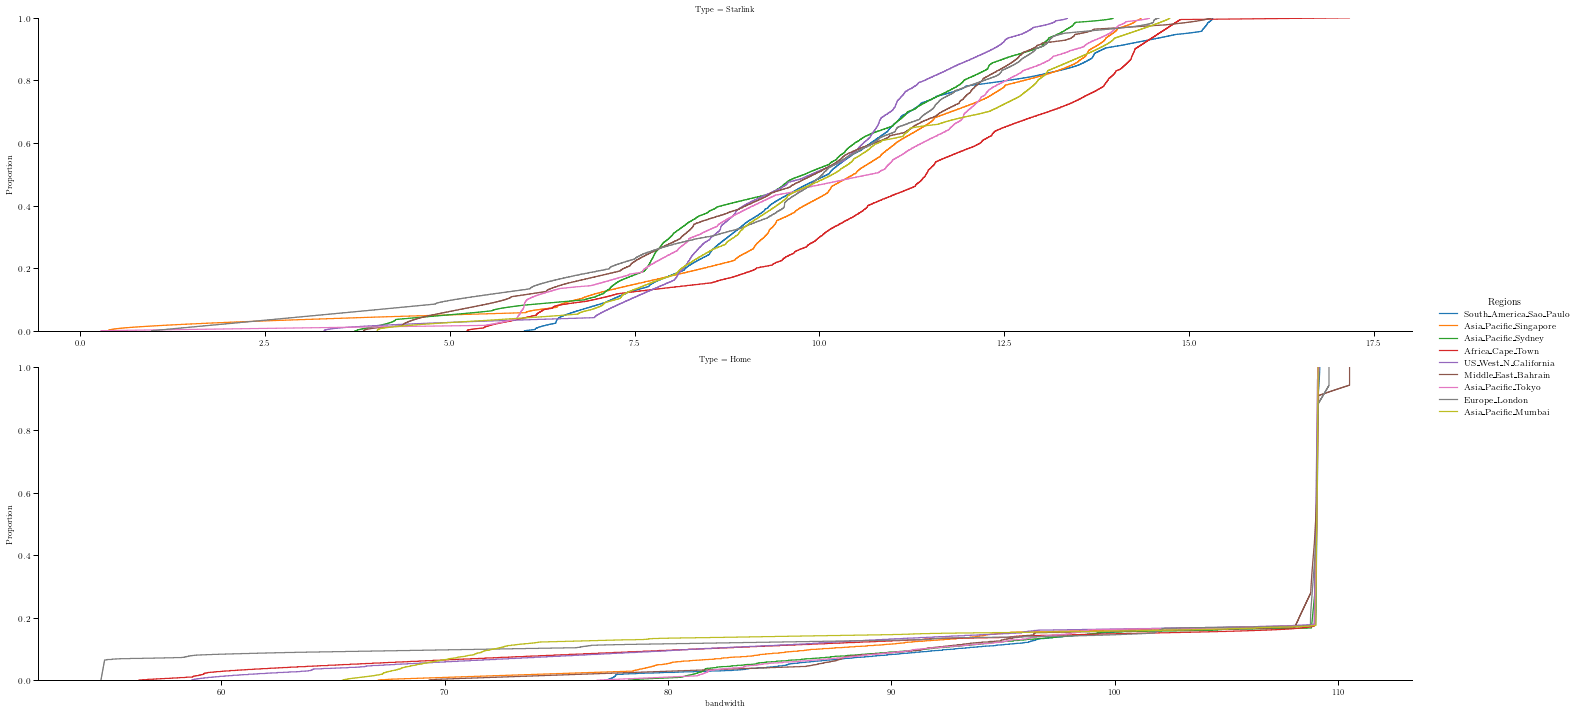

In [149]:
#fig2, ax2 = plt.subplots(figsize=(20,10))
g2 = sns.FacetGrid(data=df_unstacked, row=N_TYPE, hue=N_REGIONS, sharex=False, height=5, aspect=4)
g2.map(sns.ecdfplot, 'bandwidth')
g2.add_legend()
g2.tight_layout()
#fig2.tight_layout()

In [150]:
g.savefig(f'output/throughput/throughput.pdf', bbox_inches='tight')
g2.savefig(f'output/throughput/throughput_cdf.pdf', bbox_inches='tight')
#fig.savefig(f'output/throughput/throughput.png', bbox_inches='tight')
#fig2.savefig(f'output/throughput/throughput_cdf.png', bbox_inches='tight')